In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import os
from datetime import datetime
import random
import string
import multiprocessing as mp
import itertools

In [2]:
import matplotlib.pyplot as plt
import timeit
%load_ext memory_profiler


In [3]:
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [4]:
REWARD = 100

In [5]:
seed = 862
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

env = gym.make('CartPole-v0')
XTRA_FEAT   = 0 #masscart, masspole, length
N_ACTIONS   = env.action_space.n
N_STATES    = env.observation_space.shape[0]  +  XTRA_FEAT 
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape

In [6]:
RNDM_STRING = ''.join(random.choices(string.ascii_uppercase + string.digits, k=8)) + datetime.now().strftime("_%H_%M_%S")
print("ID: ",RNDM_STRING)
MODEL_FILENAME = './models/'+ RNDM_STRING + "_NN" + ".pt"
print("NN-MODEL FILENAME: ", MODEL_FILENAME)

ID:  UHS5ESW4_00_21_02
NN-MODEL FILENAME:  ./models/UHS5ESW4_00_21_02_NN.pt


In [7]:
def ndim_grid(start,stop, granularity):
    # Set number of dimensions
    ndims = len(start)

    # List of ranges across all dimensions
    L = [np.linspace(start[i],stop[i],granularity[i]) for i in range(ndims)]

    # Finally use meshgrid to form all combinations corresponding to all 
    # dimensions and stack them as M x ndims array
    return np.hstack((np.meshgrid(*L))).swapaxes(0,1).reshape(ndims,-1).T

In [8]:
def discretize(value, borders):
    c_pos_val, c_vel_val, p_ang_val, p_vel_val   = value
    c_pos_s  , c_vel_s  ,p_ang_s   , p_vel_s     = borders
    
    indx = np.empty_like(value).astype(np.intp)
    
    for i in range(value.shape[0]):
        if value[i] > borders[i].max():
            indx[i] = borders[i].argmax().astype(np.intp)
        else:
            indx[i] = np.where(borders[i] >= value[i])[0][0].astype(np.intp)
    return indx



In [9]:
T_LR           = 1e-2
T_GAMMA        = 0.99
T_EPSILON      = 0.98

NO_OF_NODES    = 10
NO_OF_EPISODES = 100
TIMESTEP_LIMIT = 200

print("Number of NODES: ", NO_OF_NODES)
print("Number of EPISODES per NODE", NO_OF_EPISODES)

Number of NODES:  10
Number of EPISODES per NODE 100


In [10]:
# Hyper Parameters
HIDDEN_LAYER        = 50
BATCH_SIZE          = 32
NN_LR               = 1e-3  # learning rate
NN_GAMMA            = 0.9   # reward discount
TARGET_REPLACE_ITER = 500   # target update frequency
MIN_MEMORY_CAP      = 200000

In [11]:
MAX_NO_OF_ITERATIONS = 50
MAX_NN_ITERATIONS    = 50000
print("Number of ITERATIONS: ",MAX_NO_OF_ITERATIONS)

Number of ITERATIONS:  50


In [12]:
# class Net(nn.Module):
#     def __init__(self, ):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(N_STATES, 50)
#         nn.init.kaiming_uniform_(self.fc1.weight)   # initialization
#         self.out = nn.Linear(50, N_ACTIONS)
#         nn.init.xavier_uniform_(self.out.weight)   # initialization

#     def forward(self, x):
#         x = self.fc1(x)
#         x = F.relu(x)
#         actions_value = self.out(x)
#         return actions_value

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(N_STATES, HIDDEN_LAYER)
        nn.init.kaiming_uniform_(self.fc1.weight)

        self.adv = nn.Linear(HIDDEN_LAYER, N_ACTIONS)
        nn.init.xavier_uniform_(self.adv.weight) 
    
        self.val = nn.Linear(HIDDEN_LAYER, 1)
        nn.init.xavier_uniform_(self.val.weight)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)

        adv = self.adv(x)
        val = self.val(x)
        
        return val + adv - adv.mean()
    
class D3QN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()

        self.learn_step_counter  = 0 # for target updating
        
        self.memory_counter      = 0
        self.memory              = np.zeros((int(MIN_MEMORY_CAP), N_STATES * 2 + 2)) # initialize memory
        
#         self.good_memory_counter = 0 # for storing non-terminal memories
#         self.good_memory         = np.zeros((MIN_MEMORY_CAP ,N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
#         self.bad_memory_counter  = 0 # for storing terminal memories
#         self.bad_memory          = np.zeros((MIN_MEMORY_CAP , N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        self.running_loss        = 0
        self.optimizer           = torch.optim.Adam(self.eval_net.parameters(), lr=NN_LR)
        self.loss_func           = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions_value = self.eval_net.forward(x)
        action = torch.max(actions_value, 1)[1].data.numpy()
        action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return action
    
    def get_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions = self.eval_net.forward(x).view(-1,N_ACTIONS).max(1)[1].data.numpy().astype(np.intp)
#         actions_value 
#         action = torch.max(actions_value, 1)[1].data.numpy()
#         action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return actions
    
    def get_qvals(self,x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        actions_value = self.eval_net.forward(x)
        actions_value = actions_value.data.numpy().astype(np.float16)
        return actions_value

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1
        
        sample_index_limit = min(MIN_MEMORY_CAP, self.memory_counter)
        sample_index = np.random.choice(int(sample_index_limit),int(BATCH_SIZE))
        b_memory = self.memory[sample_index,:]
#         # sample batch transitions
#         good_sample_index_limit = min(MIN_MEMORY_CAP, self.good_memory_counter)
#         bad_sample_index_limit = min(MIN_MEMORY_CAP, self.bad_memory_counter)

#         good_sample_index = np.random.choice(int(good_sample_index_limit), int(BATCH_SIZE-int(BATCH_SIZE*TERMINAL_BIAS)))
#         bad_sample_index  = np.random.choice(int(bad_sample_index_limit),  int(BATCH_SIZE*TERMINAL_BIAS))

#         b_good_memory = self.good_memory[good_sample_index, :]
#         b_bad_memory  = self.bad_memory[bad_sample_index, :]
#         b_memory      = np.vstack((b_good_memory,b_bad_memory))
        
        b_s  = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a  = torch.LongTensor( b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r  = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval   = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        a_eval   = self.eval_net(b_s).max(1)[1].view(BATCH_SIZE, 1) #best action according to eval_net
        q_next   = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + NN_GAMMA * q_next.gather(1, a_eval)   # shape (batch, 1)
        loss     = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.running_loss += loss.mean().item()
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            print('LOSS : %.3f' %(self.running_loss / TARGET_REPLACE_ITER), end="\t")
            self.running_loss = 0.0

In [13]:
def clamp(MIN_VAL, VAL, MAX_VAL):
    return max(MIN_VAL, min(VAL, MAX_VAL))

In [14]:
# ABSOLUTE LIMITS ON STATE VALUES
C_POS_ABS_MAX =  2.6
C_POS_ABS_MIN = -2.6

C_VEL_ABS_MAX =  5
C_VEL_ABS_MIN = -5

P_ANG_ABS_MAX =  0.25
P_ANG_ABS_MIN = -0.25

P_VEL_ABS_MAX =  6
P_VEL_ABS_MIN = -6

In [15]:
# SET GRANULARITY
HI_GRAIN = 40
print("HI_GRAIN = ", HI_GRAIN)

HI_GRAIN =  40


In [16]:
def mp_node_run(node_id, boundary, iteration, node_q_table):

    # SET SEED
    ###############################################
    my_seed = seed + node_id + iteration
    random.seed(my_seed)
    torch.manual_seed(my_seed)
    np.random.seed(my_seed)
    os.environ['PYTHONHASHSEED'] = str(my_seed)
    my_env = env
    my_env.seed(my_seed)
    ###############################################


    # CREATE STATE TABLE BORDERS
    ###############################################
    c_pos_s  = np.linspace(C_POS_ABS_MIN,  C_POS_ABS_MAX,  HI_GRAIN)
    c_vel_s  = np.linspace(C_VEL_ABS_MIN,  C_VEL_ABS_MAX,  HI_GRAIN)
    p_ang_s  = np.linspace(P_ANG_ABS_MIN,  P_ANG_ABS_MAX,  HI_GRAIN)
    p_vel_s  = np.linspace(P_VEL_ABS_MIN,  P_VEL_ABS_MAX,  HI_GRAIN)

    borders = [c_pos_s, c_vel_s, p_ang_s, p_vel_s]
    ###############################################
    
    my_Q_TABLE = node_q_table

    time_rec                = np.zeros(NO_OF_EPISODES)
    level_up_flag           = False
    PERFECT_RUN_COUNTER     = 10
    PERFECT_RUNS_HIGH_SCORE = 10
    level_up_metric         = 195

    exp_rec      = np.empty(N_STATES * 2 + 2)
    
#     if iteration < 3:
    my_EPSILON   = np.clip(((3%5 + 1)*0.1 + (iteration)*0.2) ,0.4,0.98)+ np.random.uniform(-0.01,0.01)
#     print(node_id, my_EPSILON)
#     else:
#         my_EPSILON   = T_EPSILON + np.random.uniform(-0.01,0.01)
    
    while True:
        i_episode = 0
        
        while i_episode < NO_OF_EPISODES:
            ep_exp_rec = np.empty(N_STATES * 2 + 2)
            time_steps = 0
            
            s = my_env.reset()
            
            while True:
                time_steps += 1
                
                #get state
                this_state = tuple(discretize(s, borders))
                
                # choose action
                if np.random.uniform() > my_EPSILON:   # greedy
                    a = (node_id%N_ACTIONS)#np.random.randint(0, N_ACTIONS)
                else:
                    a = my_Q_TABLE[this_state]

                 # take action
                s_, r, done, info = my_env.step(a)

                if done:
                    r = -REWARD
                    if time_steps >= TIMESTEP_LIMIT:
                        r = REWARD
                
                #store experience
                experience = np.hstack((s,a,r,s_))
                exp_rec = np.vstack((exp_rec, experience))

                #discretize next_state
                next_state = tuple(discretize(s_, borders))
                
                if done or time_steps >= TIMESTEP_LIMIT:
                    time_rec[i_episode] = time_steps
                    break
                s = s_

            i_episode += 1
        if i_episode >= NO_OF_EPISODES:
            i_episode = 0
            break

    exp_rec = np.delete(exp_rec, 0, 0)
#         message = "NODE#"+str(node_id) +" MAIN Q:"+ str(new_Q_TABLE.mean()) +"\t" + "NODE Q:" + str(my_Q_TABLE.mean())
#         print(message)
    
    # GET NEW STATE BOUNDARIES: +/- 25% of experienced state
    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX] = [exp_rec[:,i].max() for i in range(N_STATES)]
    [C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN] = [exp_rec[:,i].min() for i in range(N_STATES)]

    newboundary = [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX,
                   C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN]
    
    return exp_rec, time_rec, newboundary

In [17]:
total_serial_timesteps   = 0
total_parallel_timesteps = 0

In [18]:
iteration = 0
# my_dqn = D3QN()
dqn = D3QN()

# INITIALIZE BOUNDARY TO MAXIMUM VALUES
init_node_boundary = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX,
                      C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN]



# CREATE STATE COMBINATIONS
# ###############################################

init_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN],
                                    [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX],
                                    [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN])



# # GET Q-VALUES 
start = timeit.default_timer()
%memit init_q_table = dqn.get_greedy_action(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN).astype(np.intp)
stop = timeit.default_timer()
print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    
# SAVE QFILE
# node_QFILE = './Q_NPY/' + RNDM_STRING + 'QFILE' + ".npy"
# np.save(node_QFILE, init_q_table)

peak memory: 1265.66 MiB, increment: 1045.73 MiB
Quantization TIME:  0.01 minutes


In [19]:
# ENVIRONMENT FOR CHECKING NN MODEL
v_env = gym.make('CartPole-v0')
v_env.seed(seed*2)

# CREATE A POOL OF PROCESSES
pool = mp.Pool(NO_OF_NODES)

# SET INITIAL NODE BOUDNARIES FOR ALL NODES
node_boundaries = [init_node_boundary] * NO_OF_NODES
node_q_table = init_q_table



ITERATION # 0
TOTAL EXPERIENCE GENERATED:   14721
SMALLEST TIMESTEP: 8
LARGEST  TIMESTEP: 66
TOTAL SERIAL TIMESTEPS:   14721
TOTAL PARALLEL TIMESTEPS: 66


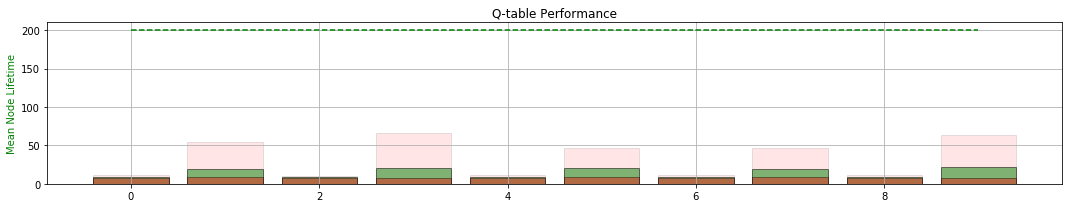

MEMORY COUNTER:  14721
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 577.090	LOSS : 528.662	LOSS : 503.751	LOSS : 496.706	LOSS : 488.400	LOSS : 503.592	LOSS : 458.587	LOSS : 504.296	LOSS : 480.940	LOSS : 468.754	LOSS : 457.705	LOSS : 455.865	LOSS : 443.309	LOSS : 422.142	LOSS : 433.206	LOSS : 420.603	LOSS : 431.686	LOSS : 411.980	LOSS : 406.841	LOSS : 417.597	
Validating... MEAN TIME:  115.21
LOSS : 394.742	LOSS : 403.632	LOSS : 374.422	LOSS : 373.183	LOSS : 382.422	LOSS : 384.772	LOSS : 368.510	LOSS : 372.479	LOSS : 361.376	LOSS : 355.125	LOSS : 348.783	LOSS : 349.876	LOSS : 343.594	LOSS : 350.517	LOSS : 356.528	LOSS : 354.522	LOSS : 350.686	LOSS : 344.576	LOSS : 347.370	LOSS : 334.475	
Validating... MEAN TIME:  134.855
LOSS : 342.098	LOSS : 354.095	LOSS : 336.421	LOSS : 334.935	LOSS : 330.762	LOSS : 322.040	LOSS : 332.114	LOSS : 323.358	LOSS : 325.011	LOSS : 327.204	LOSS : 315.476	LOSS : 327.010	LOSS : 334.436	LOSS : 321.409	LOSS : 330.916	LOSS : 323.430	LOSS : 32

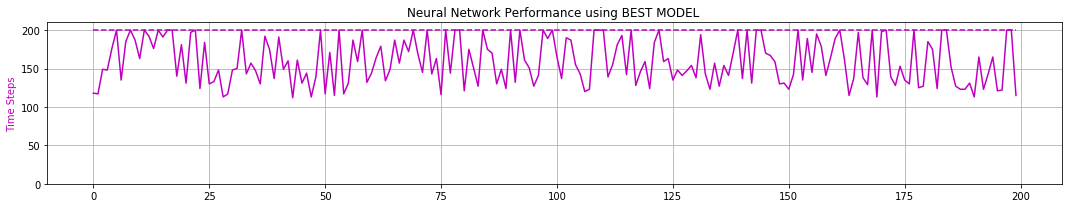

peak memory: 1337.95 MiB, increment: 1060.40 MiB
0 -max- [ 0.046  0.048  0.209  2.944]
0 -min- [-0.222 -1.995 -0.050 -0.048]

1 -max- [ 0.459  2.077  0.209  2.409]
1 -min- [-0.205 -1.516 -0.209 -2.674]

2 -max- [ 0.045  0.050  0.209  2.777]
2 -min- [-0.194 -1.808 -0.049 -0.049]

3 -max- [ 0.378  2.515  0.208  1.920]
3 -min- [-0.608 -2.060 -0.209 -2.991]

4 -max- [ 0.050  0.050  0.209  2.959]
4 -min- [-0.190 -1.973 -0.049 -0.050]

5 -max- [ 0.502  2.446  0.208  2.506]
5 -min- [-0.146 -1.563 -0.209 -2.750]

6 -max- [ 0.050  0.050  0.208  2.961]
6 -min- [-0.210 -1.992 -0.049 -0.049]

7 -max- [ 0.451  2.307  0.204  2.005]
7 -min- [-0.284 -1.514 -0.209 -2.719]

8 -max- [ 0.049  0.049  0.209  2.948]
8 -min- [-0.195 -1.927 -0.048 -0.048]

9 -max- [ 0.534  2.117  0.207  1.705]
9 -min- [-0.176 -1.020 -0.209 -2.922]

Quantization TIME:  0.02 minutes


ITERATION # 1
TOTAL EXPERIENCE GENERATED:   44206
SMALLEST TIMESTEP: 9
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   58927
TOTAL PARALLEL TIMES

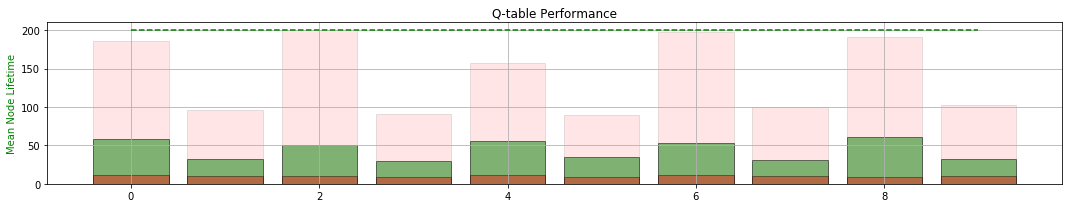

MEMORY COUNTER:  58927
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 335.750	LOSS : 348.961	LOSS : 343.572	LOSS : 335.082	LOSS : 309.665	LOSS : 315.556	LOSS : 308.785	LOSS : 301.009	LOSS : 307.669	LOSS : 288.756	LOSS : 287.965	LOSS : 285.952	LOSS : 291.231	LOSS : 282.629	LOSS : 284.668	LOSS : 272.533	LOSS : 272.068	LOSS : 281.798	LOSS : 269.956	LOSS : 264.455	
Validating... MEAN TIME:  166.81
LOSS : 270.307	LOSS : 264.686	LOSS : 262.426	LOSS : 269.156	LOSS : 272.754	LOSS : 272.379	LOSS : 270.003	LOSS : 270.402	LOSS : 266.008	LOSS : 264.295	LOSS : 270.937	LOSS : 257.532	LOSS : 279.299	LOSS : 248.397	LOSS : 285.373	LOSS : 267.194	LOSS : 284.610	LOSS : 260.391	LOSS : 266.077	LOSS : 283.814	
Validating... MEAN TIME:  151.875
LOSS : 287.047	LOSS : 275.217	LOSS : 273.653	LOSS : 284.355	LOSS : 285.199	LOSS : 286.095	LOSS : 281.442	LOSS : 273.452	LOSS : 276.924	LOSS : 272.567	LOSS : 270.297	LOSS : 283.844	LOSS : 288.307	LOSS : 296.465	LOSS : 281.296	LOSS : 291.318	LOSS : 29

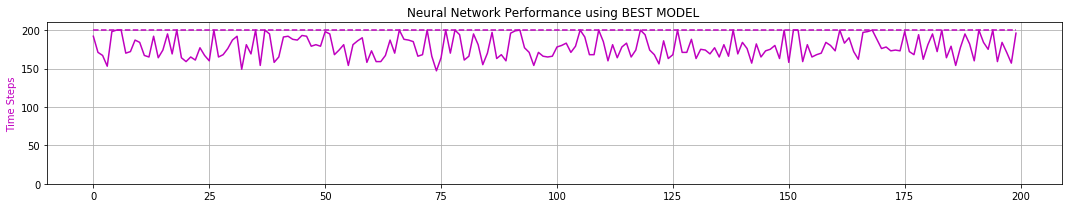

peak memory: 1422.90 MiB, increment: 1083.70 MiB
0 -max- [ 1.127  1.675  0.209  2.593]
0 -min- [-1.209 -1.974 -0.201 -1.322]

1 -max- [ 0.184  1.580  0.049  1.191]
1 -min- [-1.140 -1.887 -0.209 -2.361]

2 -max- [ 0.990  1.808  0.209  2.302]
2 -min- [-0.784 -1.675 -0.099 -1.263]

3 -max- [ 0.221  1.380  0.050  1.290]
3 -min- [-0.944 -1.689 -0.209 -2.304]

4 -max- [ 1.076  1.494  0.209  2.473]
4 -min- [-0.704 -1.877 -0.090 -1.323]

5 -max- [ 0.208  1.409  0.050  1.108]
5 -min- [-1.076 -1.834 -0.209 -2.135]

6 -max- [ 0.978  1.475  0.209  2.336]
6 -min- [-1.164 -2.326 -0.209 -1.367]

7 -max- [ 0.232  1.401  0.049  1.303]
7 -min- [-1.126 -1.874 -0.209 -2.229]

8 -max- [ 1.028  1.649  0.209  2.612]
8 -min- [-1.786 -2.236 -0.209 -2.306]

9 -max- [ 0.199  1.610  0.046  1.223]
9 -min- [-1.033 -1.703 -0.209 -2.415]

Quantization TIME:  0.02 minutes


ITERATION # 2
TOTAL EXPERIENCE GENERATED:   97495
SMALLEST TIMESTEP: 9
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   156422
TOTAL PARALLEL TIME

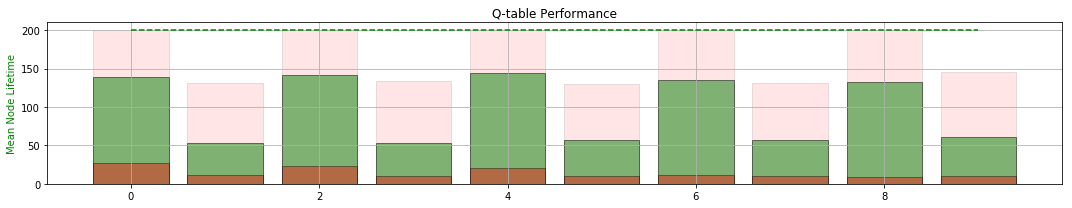

MEMORY COUNTER:  156422
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 251.818	LOSS : 234.666	LOSS : 243.971	LOSS : 230.328	LOSS : 228.132	LOSS : 232.686	LOSS : 223.931	LOSS : 218.061	LOSS : 217.750	LOSS : 209.294	LOSS : 206.903	LOSS : 214.248	LOSS : 209.394	LOSS : 196.108	LOSS : 212.203	LOSS : 191.764	LOSS : 189.564	LOSS : 201.046	LOSS : 202.977	LOSS : 202.872	
Validating... MEAN TIME:  194.76
LOSS : 194.747	LOSS : 192.988	LOSS : 201.687	LOSS : 200.254	LOSS : 187.063	LOSS : 200.008	LOSS : 199.341	LOSS : 188.020	LOSS : 187.541	LOSS : 200.180	LOSS : 192.925	LOSS : 193.836	LOSS : 182.470	LOSS : 198.278	LOSS : 196.343	LOSS : 184.881	LOSS : 184.796	LOSS : 189.263	LOSS : 187.474	LOSS : 192.864	
Validating... MEAN TIME:  197.04
LOSS : 203.390	LOSS : 193.227	LOSS : 205.830	LOSS : 182.159	LOSS : 203.783	LOSS : 189.560	LOSS : 191.870	LOSS : 189.748	LOSS : 210.975	LOSS : 191.720	LOSS : 203.920	LOSS : 210.497	LOSS : 186.581	LOSS : 207.139	LOSS : 203.967	LOSS : 213.940	LOSS : 20

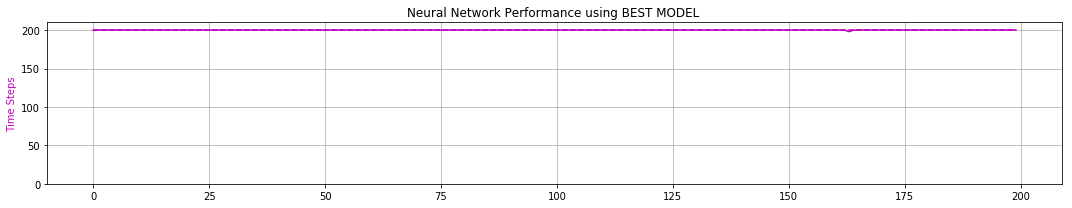

peak memory: 1442.11 MiB, increment: 1017.50 MiB
0 -max- [ 1.684  1.567  0.208  2.341]
0 -min- [-2.382 -3.427 -0.209 -2.360]

1 -max- [ 0.186  1.357  0.050  1.631]
1 -min- [-2.370 -2.928 -0.209 -2.253]

2 -max- [ 1.822  1.564  0.209  2.554]
2 -min- [-2.391 -3.014 -0.209 -2.283]

3 -max- [ 0.198  1.232  0.050  1.608]
3 -min- [-2.385 -2.920 -0.209 -2.445]

4 -max- [ 2.035  2.005  0.209  2.389]
4 -min- [-2.400 -2.967 -0.209 -2.507]

5 -max- [ 0.205  1.179  0.053  1.629]
5 -min- [-2.373 -3.000 -0.209 -2.250]

6 -max- [ 2.267  2.198  0.209  2.097]
6 -min- [-2.394 -3.023 -0.209 -2.204]

7 -max- [ 0.211  1.517  0.049  1.639]
7 -min- [-2.331 -2.631 -0.209 -2.328]

8 -max- [ 1.864  1.721  0.209  2.285]
8 -min- [-2.393 -3.215 -0.209 -2.268]

9 -max- [ 0.188  1.547  0.049  1.595]
9 -min- [-2.392 -3.180 -0.209 -2.419]

Quantization TIME:  0.02 minutes


ITERATION # 3
TOTAL EXPERIENCE GENERATED:   168172
SMALLEST TIMESTEP: 12
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   324594
TOTAL PARALLEL TI

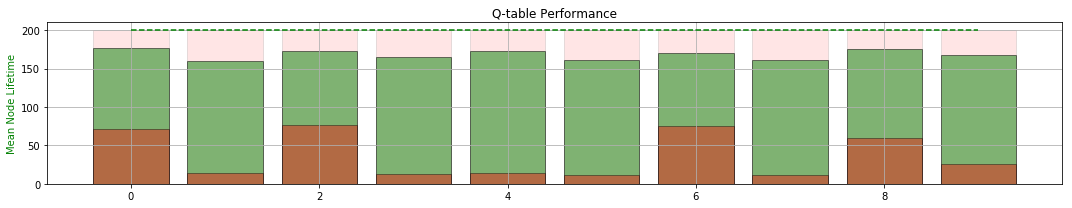

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 82.604	LOSS : 84.368	LOSS : 96.783	LOSS : 82.208	LOSS : 88.160	LOSS : 86.927	LOSS : 75.165	LOSS : 82.058	LOSS : 78.903	LOSS : 76.868	LOSS : 78.584	LOSS : 76.901	LOSS : 70.439	LOSS : 71.986	LOSS : 79.487	LOSS : 67.334	LOSS : 72.559	LOSS : 68.466	LOSS : 73.421	LOSS : 68.288	
Validating... MEAN TIME:  130.425
LOSS : 74.390	LOSS : 68.066	LOSS : 70.844	LOSS : 76.702	LOSS : 73.203	LOSS : 64.463	LOSS : 64.713	LOSS : 64.500	LOSS : 72.947	LOSS : 68.056	LOSS : 76.365	LOSS : 64.437	LOSS : 64.401	LOSS : 68.839	LOSS : 79.789	LOSS : 78.673	LOSS : 82.239	LOSS : 74.068	LOSS : 72.352	LOSS : 82.854	
Validating... MEAN TIME:  117.95
LOSS : 70.240	LOSS : 69.439	LOSS : 69.813	LOSS : 69.622	LOSS : 72.530	LOSS : 80.958	LOSS : 67.680	LOSS : 70.011	LOSS : 75.776	LOSS : 73.472	LOSS : 69.787	LOSS : 77.391	LOSS : 74.325	LOSS : 72.381	LOSS : 71.330	LOSS : 70.372	LOSS : 73.435	LOSS : 67.580	LOSS : 63.340	LOSS : 69.715	
Validat

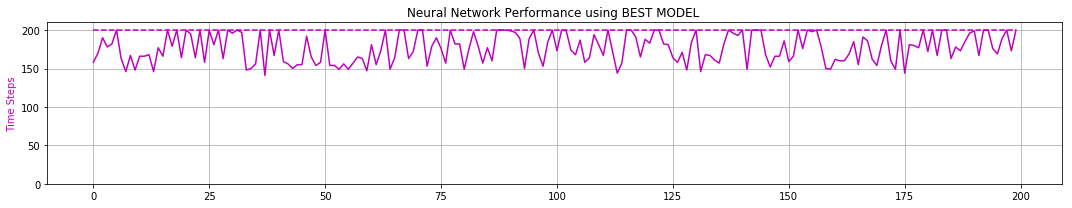

peak memory: 1449.36 MiB, increment: 1054.49 MiB
0 -max- [ 0.184  1.125  0.159  1.946]
0 -min- [-2.400 -2.072 -0.208 -1.686]

1 -max- [ 0.174  1.129  0.116  1.919]
1 -min- [-2.400 -2.234 -0.209 -1.763]

2 -max- [ 1.971  1.973  0.201  1.944]
2 -min- [-2.400 -2.073 -0.209 -1.672]

3 -max- [ 0.186  1.132  0.114  1.807]
3 -min- [-2.399 -2.093 -0.205 -1.785]

4 -max- [ 0.166  1.027  0.170  1.885]
4 -min- [-2.399 -2.101 -0.207 -1.668]

5 -max- [ 0.180  1.021  0.110  1.816]
5 -min- [-2.399 -2.219 -0.207 -1.889]

6 -max- [ 0.178  1.025  0.162  1.788]
6 -min- [-2.399 -2.168 -0.209 -1.672]

7 -max- [ 0.156  1.024  0.120  1.749]
7 -min- [-2.400 -2.218 -0.209 -1.657]

8 -max- [ 0.171  1.026  0.176  1.879]
8 -min- [-2.400 -2.163 -0.208 -1.677]

9 -max- [ 0.159  1.172  0.117  1.825]
9 -min- [-2.400 -2.174 -0.204 -1.829]

Quantization TIME:  0.02 minutes


ITERATION # 4
TOTAL EXPERIENCE GENERATED:   63322
SMALLEST TIMESTEP: 11
LARGEST  TIMESTEP: 132
TOTAL SERIAL TIMESTEPS:   387916
TOTAL PARALLEL TIM

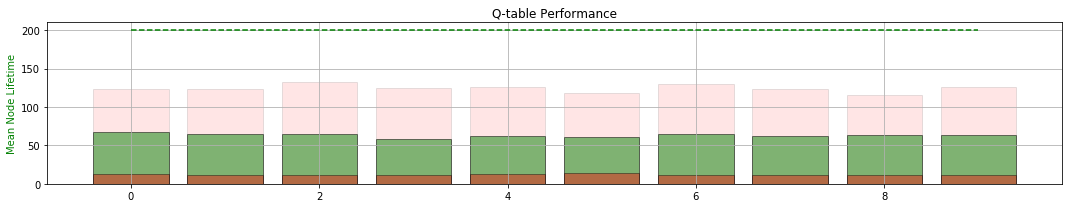

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 84.289	LOSS : 80.488	LOSS : 85.001	LOSS : 87.971	LOSS : 75.623	LOSS : 82.983	LOSS : 83.634	LOSS : 77.415	LOSS : 87.987	LOSS : 85.204	LOSS : 85.651	LOSS : 86.007	LOSS : 81.076	LOSS : 83.949	LOSS : 92.302	LOSS : 82.848	LOSS : 80.087	LOSS : 87.685	LOSS : 83.564	LOSS : 85.551	
Validating... MEAN TIME:  147.005
LOSS : 88.725	LOSS : 91.389	LOSS : 80.202	LOSS : 90.831	LOSS : 80.095	LOSS : 85.061	LOSS : 83.816	LOSS : 77.394	LOSS : 76.445	LOSS : 75.709	LOSS : 91.293	LOSS : 87.847	LOSS : 84.953	LOSS : 96.748	LOSS : 83.757	LOSS : 97.342	LOSS : 85.303	LOSS : 95.087	LOSS : 85.705	LOSS : 84.818	
Validating... MEAN TIME:  130.05
LOSS : 78.673	LOSS : 85.721	LOSS : 87.703	LOSS : 78.016	LOSS : 87.021	LOSS : 81.448	LOSS : 84.570	LOSS : 94.797	LOSS : 91.537	LOSS : 92.831	LOSS : 86.375	LOSS : 89.373	LOSS : 97.376	LOSS : 91.547	LOSS : 86.931	LOSS : 79.810	LOSS : 86.548	LOSS : 90.366	LOSS : 94.101	LOSS : 84.965	
Validat

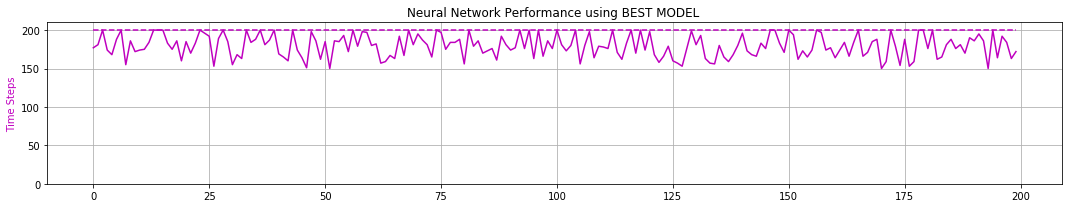

peak memory: 1462.73 MiB, increment: 1018.03 MiB
0 -max- [ 0.209  1.054  0.149  1.550]
0 -min- [-2.390 -2.779 -0.209 -2.081]

1 -max- [ 0.198  1.046  0.150  1.541]
1 -min- [-2.391 -2.931 -0.209 -2.100]

2 -max- [ 0.213  1.181  0.208  2.113]
2 -min- [-2.399 -2.885 -0.209 -2.197]

3 -max- [ 0.201  0.848  0.141  1.536]
3 -min- [-2.387 -2.917 -0.209 -2.136]

4 -max- [ 0.202  1.009  0.156  1.561]
4 -min- [-2.380 -2.895 -0.209 -1.951]

5 -max- [ 0.206  0.961  0.159  1.515]
5 -min- [-2.361 -2.758 -0.209 -2.017]

6 -max- [ 0.186  0.838  0.143  1.553]
6 -min- [-2.397 -2.895 -0.209 -1.675]

7 -max- [ 0.205  0.995  0.153  1.557]
7 -min- [-2.367 -2.920 -0.209 -1.962]

8 -max- [ 0.193  0.857  0.141  1.521]
8 -min- [-2.382 -2.766 -0.209 -1.883]

9 -max- [ 0.196  0.837  0.143  1.591]
9 -min- [-2.373 -2.773 -0.209 -2.140]

Quantization TIME:  0.02 minutes


ITERATION # 5
TOTAL EXPERIENCE GENERATED:   28508
SMALLEST TIMESTEP: 9
LARGEST  TIMESTEP: 132
TOTAL SERIAL TIMESTEPS:   416424
TOTAL PARALLEL TIME

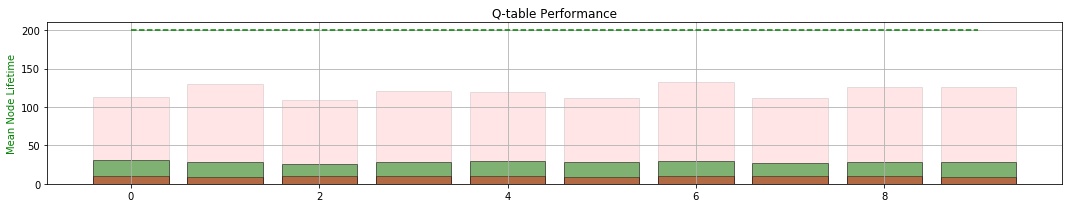

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 128.056	LOSS : 131.867	LOSS : 130.470	LOSS : 127.918	LOSS : 132.190	LOSS : 120.414	LOSS : 134.117	LOSS : 127.425	LOSS : 133.823	LOSS : 118.724	LOSS : 117.672	LOSS : 130.258	LOSS : 124.134	LOSS : 127.546	LOSS : 131.016	LOSS : 130.249	LOSS : 133.433	LOSS : 135.530	LOSS : 132.882	LOSS : 136.032	
Validating... MEAN TIME:  128.63
LOSS : 131.377	LOSS : 127.242	LOSS : 127.364	LOSS : 123.067	LOSS : 125.679	LOSS : 129.942	LOSS : 119.038	LOSS : 130.810	LOSS : 123.747	LOSS : 136.182	LOSS : 137.187	LOSS : 134.244	LOSS : 128.057	LOSS : 134.514	LOSS : 140.218	LOSS : 125.392	LOSS : 133.019	LOSS : 121.851	LOSS : 138.149	LOSS : 126.285	
Validating... MEAN TIME:  166.715
LOSS : 119.101	LOSS : 127.514	LOSS : 134.316	LOSS : 124.302	LOSS : 139.662	LOSS : 129.379	LOSS : 125.173	LOSS : 134.526	LOSS : 126.349	LOSS : 137.491	LOSS : 138.558	LOSS : 132.431	LOSS : 134.365	LOSS : 131.285	LOSS : 129.717	LOSS : 134.420	LOSS : 1

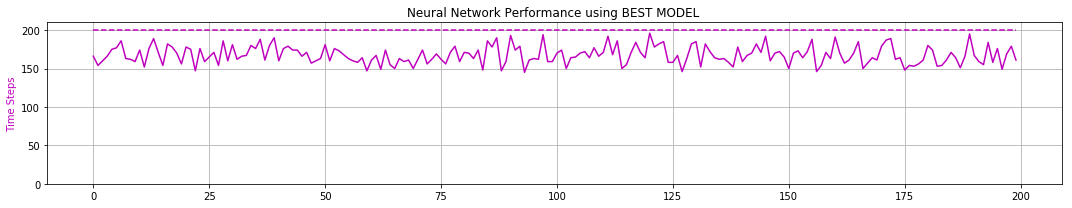

peak memory: 1480.05 MiB, increment: 996.16 MiB
0 -max- [ 0.205  1.529  0.204  2.294]
0 -min- [-1.295 -2.331 -0.209 -2.529]

1 -max- [ 0.223  1.612  0.189  2.121]
1 -min- [-2.376 -2.725 -0.209 -2.505]

2 -max- [ 0.211  1.535  0.202  2.145]
2 -min- [-1.451 -2.137 -0.209 -2.498]

3 -max- [ 0.207  1.544  0.201  2.125]
3 -min- [-2.293 -2.401 -0.209 -2.586]

4 -max- [ 0.218  1.523  0.196  2.223]
4 -min- [-2.149 -2.300 -0.209 -2.555]

5 -max- [ 0.192  1.586  0.204  2.209]
5 -min- [-1.591 -2.308 -0.209 -2.550]

6 -max- [ 0.208  1.541  0.201  2.098]
6 -min- [-2.394 -2.732 -0.209 -2.444]

7 -max- [ 0.195  1.543  0.199  2.265]
7 -min- [-1.414 -2.314 -0.209 -2.555]

8 -max- [ 0.206  1.546  0.198  2.209]
8 -min- [-2.381 -2.790 -0.209 -2.518]

9 -max- [ 0.205  1.567  0.191  2.127]
9 -min- [-2.354 -2.384 -0.209 -2.701]

Quantization TIME:  0.02 minutes


ITERATION # 6
TOTAL EXPERIENCE GENERATED:   116421
SMALLEST TIMESTEP: 11
LARGEST  TIMESTEP: 144
TOTAL SERIAL TIMESTEPS:   532845
TOTAL PARALLEL TIM

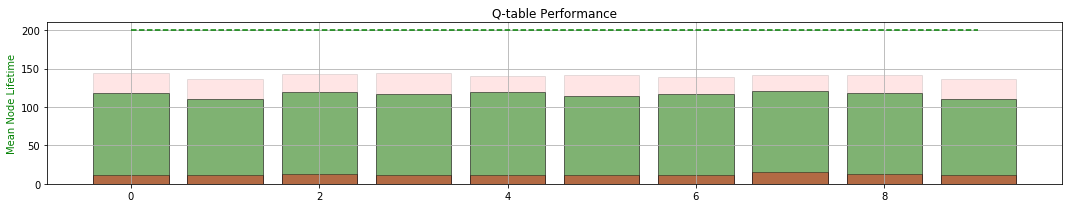

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 185.127	LOSS : 171.141	LOSS : 169.778	LOSS : 177.796	LOSS : 158.163	LOSS : 160.585	LOSS : 163.499	LOSS : 166.753	LOSS : 164.863	LOSS : 170.287	LOSS : 155.553	LOSS : 155.797	LOSS : 162.595	LOSS : 162.510	LOSS : 157.256	LOSS : 164.335	LOSS : 142.203	LOSS : 169.359	LOSS : 154.371	LOSS : 162.284	
Validating... MEAN TIME:  115.44
LOSS : 171.114	LOSS : 155.240	LOSS : 169.661	LOSS : 152.195	LOSS : 159.447	LOSS : 160.454	LOSS : 155.337	LOSS : 152.570	LOSS : 180.058	LOSS : 179.050	LOSS : 184.280	LOSS : 163.607	LOSS : 155.136	LOSS : 149.589	LOSS : 161.418	LOSS : 158.990	LOSS : 165.273	LOSS : 170.380	LOSS : 170.408	LOSS : 173.354	
Validating... MEAN TIME:  116.79
LOSS : 171.273	LOSS : 151.538	LOSS : 162.215	LOSS : 152.112	LOSS : 161.103	LOSS : 160.420	LOSS : 164.212	LOSS : 168.182	LOSS : 169.664	LOSS : 165.008	LOSS : 175.099	LOSS : 168.655	LOSS : 165.307	LOSS : 171.151	LOSS : 165.651	LOSS : 171.000	LOSS : 16

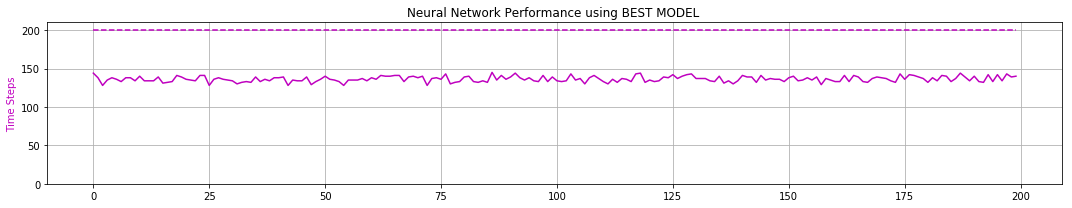

peak memory: 1519.25 MiB, increment: 1015.70 MiB
0 -max- [ 0.205  1.014  0.072  1.249]
0 -min- [-2.400 -2.764 -0.209 -1.354]

1 -max- [ 0.201  0.832  0.071  1.264]
1 -min- [-2.399 -2.607 -0.209 -1.651]

2 -max- [ 0.199  0.644  0.081  1.419]
2 -min- [-2.400 -2.697 -0.209 -1.100]

3 -max- [ 0.206  0.831  0.065  1.259]
3 -min- [-2.399 -2.609 -0.209 -1.425]

4 -max- [ 0.179  0.642  0.091  1.269]
4 -min- [-2.400 -2.798 -0.209 -1.204]

5 -max- [ 0.205  0.999  0.068  1.281]
5 -min- [-2.400 -2.605 -0.209 -1.557]

6 -max- [ 0.177  0.641  0.073  1.494]
6 -min- [-2.399 -2.594 -0.209 -1.344]

7 -max- [ 0.188  0.823  0.069  1.484]
7 -min- [-2.400 -2.698 -0.209 -1.356]

8 -max- [ 0.184  0.641  0.081  1.287]
8 -min- [-2.400 -2.700 -0.209 -1.341]

9 -max- [ 0.180  0.837  0.071  1.264]
9 -min- [-2.400 -2.600 -0.209 -1.405]

Quantization TIME:  0.02 minutes


ITERATION # 7
TOTAL EXPERIENCE GENERATED:   117940
SMALLEST TIMESTEP: 38
LARGEST  TIMESTEP: 131
TOTAL SERIAL TIMESTEPS:   650785
TOTAL PARALLEL TI

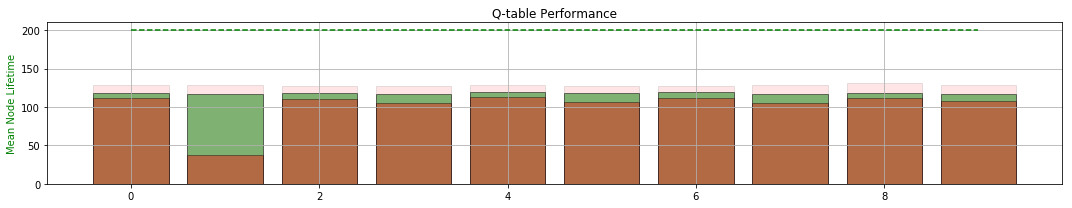

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 154.843	LOSS : 144.594	LOSS : 124.479	LOSS : 121.954	LOSS : 122.243	LOSS : 133.920	LOSS : 106.589	LOSS : 120.699	LOSS : 109.941	LOSS : 127.876	LOSS : 135.880	LOSS : 117.836	LOSS : 132.241	LOSS : 152.181	LOSS : 131.796	LOSS : 117.909	LOSS : 139.090	LOSS : 138.311	LOSS : 126.109	LOSS : 137.410	
Validating... MEAN TIME:  195.38
LOSS : 132.474	LOSS : 135.093	LOSS : 124.561	LOSS : 123.591	LOSS : 136.195	LOSS : 115.957	LOSS : 101.002	LOSS : 117.439	LOSS : 121.322	LOSS : 115.893	LOSS : 111.248	LOSS : 132.580	LOSS : 122.210	LOSS : 113.643	LOSS : 133.887	LOSS : 103.276	LOSS : 116.464	LOSS : 112.553	LOSS : 118.569	LOSS : 128.080	
Validating... MEAN TIME:  110.75
LOSS : 123.332	LOSS : 109.989	LOSS : 118.480	LOSS : 101.871	LOSS : 130.393	LOSS : 113.959	LOSS : 132.224	LOSS : 111.003	LOSS : 116.245	LOSS : 107.236	LOSS : 109.321	LOSS : 118.137	LOSS : 122.397	LOSS : 109.658	LOSS : 113.560	LOSS : 121.649	LOSS : 11

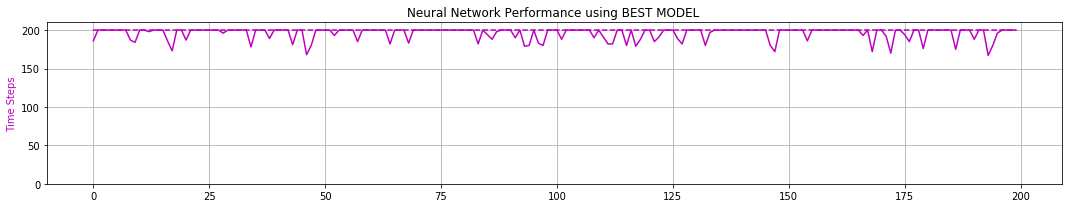

peak memory: 1482.38 MiB, increment: 1017.64 MiB
0 -max- [ 0.154  0.631  0.047  1.243]
0 -min- [-2.399 -2.706 -0.205 -0.938]

1 -max- [ 0.152  0.631  0.049  0.682]
1 -min- [-2.399 -2.784 -0.209 -1.042]

2 -max- [ 0.159  0.630  0.049  0.666]
2 -min- [-2.400 -2.771 -0.205 -0.985]

3 -max- [ 0.138  0.770  0.046  0.704]
3 -min- [-2.400 -2.795 -0.209 -1.170]

4 -max- [ 0.155  0.627  0.049  0.857]
4 -min- [-2.399 -2.738 -0.204 -1.005]

5 -max- [ 0.138  0.630  0.049  0.589]
5 -min- [-2.400 -2.712 -0.209 -0.938]

6 -max- [ 0.147  0.626  0.046  0.873]
6 -min- [-2.400 -2.615 -0.202 -0.932]

7 -max- [ 0.149  0.770  0.050  0.692]
7 -min- [-2.399 -2.699 -0.209 -1.312]

8 -max- [ 0.142  0.631  0.047  0.681]
8 -min- [-2.400 -2.705 -0.203 -0.977]

9 -max- [ 0.152  0.821  0.051  0.950]
9 -min- [-2.400 -2.755 -0.209 -1.412]

Quantization TIME:  0.02 minutes


ITERATION # 8
TOTAL EXPERIENCE GENERATED:   168435
SMALLEST TIMESTEP: 15
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   819220
TOTAL PARALLEL TI

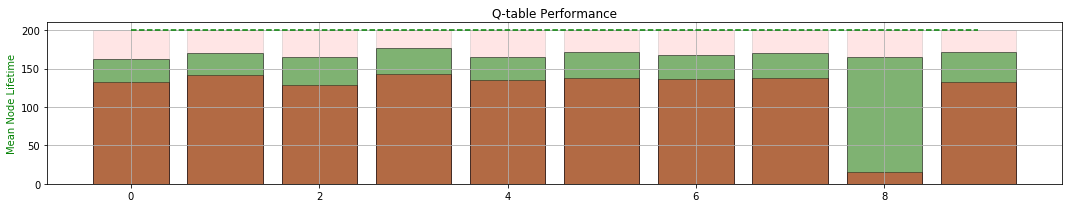

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 118.114	LOSS : 96.313	LOSS : 96.265	LOSS : 93.004	LOSS : 81.499	LOSS : 93.609	LOSS : 75.830	LOSS : 83.195	LOSS : 85.061	LOSS : 102.980	LOSS : 88.074	LOSS : 97.569	LOSS : 100.741	LOSS : 89.492	LOSS : 87.410	LOSS : 82.611	LOSS : 83.356	LOSS : 91.702	LOSS : 80.937	LOSS : 80.121	
Validating... MEAN TIME:  164.625
LOSS : 78.540	LOSS : 77.818	LOSS : 70.012	LOSS : 78.926	LOSS : 75.929	LOSS : 58.428	LOSS : 62.597	LOSS : 63.730	LOSS : 70.211	LOSS : 69.875	LOSS : 56.477	LOSS : 55.679	LOSS : 64.209	LOSS : 62.035	LOSS : 65.275	LOSS : 60.801	LOSS : 62.665	LOSS : 56.490	LOSS : 59.970	LOSS : 65.336	
Validating... MEAN TIME:  123.765
LOSS : 61.806	LOSS : 66.537	LOSS : 57.255	LOSS : 52.983	LOSS : 59.812	LOSS : 60.712	LOSS : 54.820	LOSS : 59.909	LOSS : 61.191	LOSS : 52.152	LOSS : 65.236	LOSS : 65.508	LOSS : 58.636	LOSS : 65.790	LOSS : 53.596	LOSS : 59.718	LOSS : 69.372	LOSS : 60.914	LOSS : 53.353	LOSS : 60.377	
Val

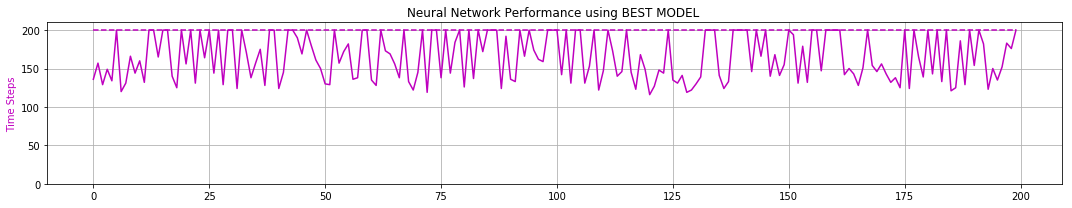

peak memory: 1511.52 MiB, increment: 1021.03 MiB
0 -max- [ 2.400  2.406  0.209  1.188]
0 -min- [-0.167 -0.829 -0.048 -0.879]

1 -max- [ 2.400  2.392  0.209  1.183]
1 -min- [-0.110 -0.829 -0.052 -0.882]

2 -max- [ 2.400  2.412  0.209  1.668]
2 -min- [-0.176 -1.154 -0.053 -0.868]

3 -max- [ 2.399  2.416  0.209  1.178]
3 -min- [-0.517 -1.277 -0.081 -1.033]

4 -max- [ 2.399  2.415  0.209  1.186]
4 -min- [-0.129 -0.828 -0.049 -0.875]

5 -max- [ 2.400  2.342  0.209  1.171]
5 -min- [-0.388 -0.824 -0.053 -1.024]

6 -max- [ 2.400  2.587  0.209  1.188]
6 -min- [-0.120 -0.826 -0.050 -0.892]

7 -max- [ 2.397  2.402  0.209  1.186]
7 -min- [-0.115 -0.829 -0.060 -1.002]

8 -max- [ 2.400  2.563  0.209  1.448]
8 -min- [-0.169 -0.982 -0.051 -0.949]

9 -max- [ 2.398  2.580  0.209  1.192]
9 -min- [-0.150 -0.827 -0.054 -0.846]

Quantization TIME:  0.02 minutes


ITERATION # 9
TOTAL EXPERIENCE GENERATED:   89413
SMALLEST TIMESTEP: 31
LARGEST  TIMESTEP: 159
TOTAL SERIAL TIMESTEPS:   908633
TOTAL PARALLEL TIM

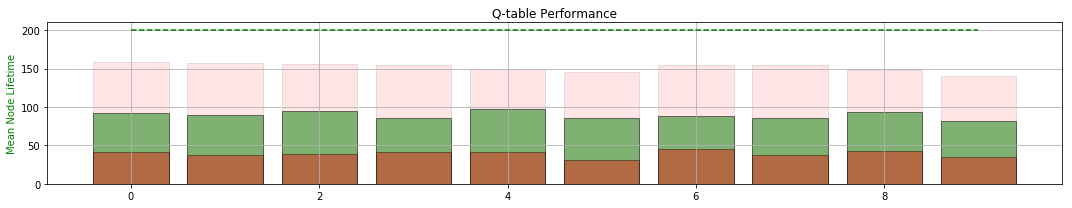

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 137.202	LOSS : 160.127	LOSS : 161.804	LOSS : 117.202	LOSS : 126.530	LOSS : 101.981	LOSS : 109.528	LOSS : 105.282	LOSS : 101.974	LOSS : 89.063	LOSS : 95.039	LOSS : 103.732	LOSS : 101.870	LOSS : 96.072	LOSS : 103.525	LOSS : 93.381	LOSS : 95.367	LOSS : 108.887	LOSS : 99.312	LOSS : 111.630	
Validating... MEAN TIME:  200.0
LOSS : 108.972	LOSS : 92.524	LOSS : 98.946	LOSS : 87.015	LOSS : 90.530	LOSS : 85.784	LOSS : 104.756	LOSS : 105.908	LOSS : 91.571	LOSS : 86.166	LOSS : 84.652	LOSS : 103.142	LOSS : 97.321	LOSS : 102.092	LOSS : 86.849	LOSS : 93.303	LOSS : 96.370	LOSS : 96.649	LOSS : 97.813	LOSS : 94.201	
Validating... MEAN TIME:  142.135
LOSS : 106.953	LOSS : 89.443	LOSS : 97.866	LOSS : 97.324	LOSS : 87.538	LOSS : 79.959	LOSS : 110.848	LOSS : 113.010	LOSS : 105.567	LOSS : 105.808	LOSS : 106.859	LOSS : 117.002	LOSS : 106.535	LOSS : 97.752	LOSS : 109.130	LOSS : 103.695	LOSS : 104.080	LOSS : 93.162	LOSS : 

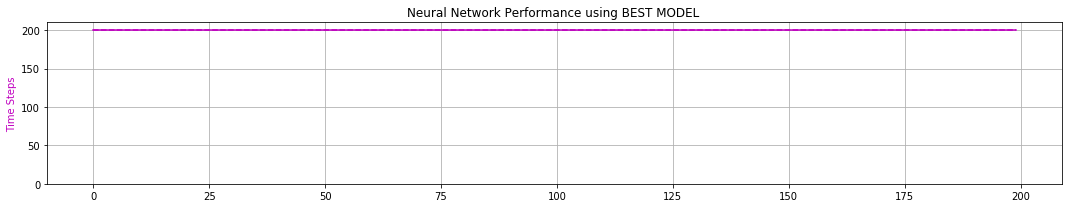

peak memory: 1516.79 MiB, increment: 978.32 MiB
0 -max- [ 0.209  0.431  0.049  0.683]
0 -min- [-2.398 -3.494 -0.209 -0.799]

1 -max- [ 0.188  0.629  0.046  0.682]
1 -min- [-2.399 -3.509 -0.209 -0.869]

2 -max- [ 0.193  0.410  0.049  0.957]
2 -min- [-2.399 -3.651 -0.209 -0.701]

3 -max- [ 0.191  0.621  0.049  0.680]
3 -min- [-2.398 -3.533 -0.209 -0.828]

4 -max- [ 0.224  0.425  0.046  0.680]
4 -min- [-2.398 -3.474 -0.209 -0.790]

5 -max- [ 0.213  0.627  0.050  0.681]
5 -min- [-2.398 -3.510 -0.209 -1.092]

6 -max- [ 0.339  0.600  0.065  0.682]
6 -min- [-2.397 -3.502 -0.209 -0.798]

7 -max- [ 0.203  0.576  0.051  0.687]
7 -min- [-2.399 -3.536 -0.209 -1.095]

8 -max- [ 0.188  0.427  0.047  0.897]
8 -min- [-2.400 -3.526 -0.209 -0.793]

9 -max- [ 0.212  0.588  0.051  0.668]
9 -min- [-2.399 -3.508 -0.209 -1.109]

Quantization TIME:  0.02 minutes


ITERATION # 10
TOTAL EXPERIENCE GENERATED:   151620
SMALLEST TIMESTEP: 118
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   1060253
TOTAL PARALLEL 

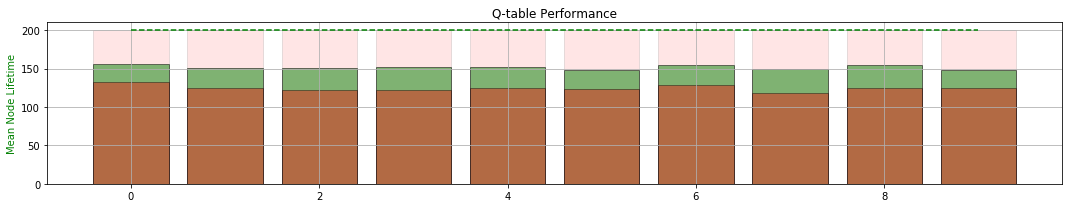

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 69.824	LOSS : 78.752	LOSS : 93.242	LOSS : 98.645	LOSS : 100.959	LOSS : 109.144	LOSS : 93.524	LOSS : 95.011	LOSS : 105.437	LOSS : 101.049	LOSS : 88.067	LOSS : 93.270	LOSS : 89.296	LOSS : 88.456	LOSS : 96.705	LOSS : 82.616	LOSS : 95.414	LOSS : 83.110	LOSS : 79.846	LOSS : 90.204	
Validating... MEAN TIME:  113.87
LOSS : 99.992	LOSS : 80.781	LOSS : 90.000	LOSS : 100.238	LOSS : 95.191	LOSS : 113.891	LOSS : 88.776	LOSS : 106.334	LOSS : 102.812	LOSS : 101.569	LOSS : 107.323	LOSS : 93.738	LOSS : 109.908	LOSS : 101.278	LOSS : 113.671	LOSS : 102.922	LOSS : 87.522	LOSS : 101.516	LOSS : 92.364	LOSS : 103.774	
Validating... MEAN TIME:  129.24
LOSS : 96.311	LOSS : 97.891	LOSS : 106.765	LOSS : 74.747	LOSS : 80.350	LOSS : 114.352	LOSS : 95.463	LOSS : 91.669	LOSS : 90.785	LOSS : 95.197	LOSS : 92.138	LOSS : 87.648	LOSS : 91.796	LOSS : 89.479	LOSS : 89.156	LOSS : 78.506	LOSS : 80.847	LOSS : 88.017	LOSS : 81.321	LOSS 

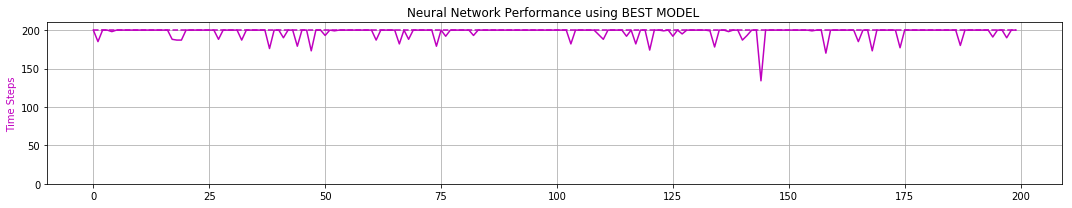

peak memory: 1465.05 MiB, increment: 1035.11 MiB
0 -max- [ 0.127  0.439  0.046  0.838]
0 -min- [-1.589 -1.830 -0.209 -1.022]

1 -max- [ 0.121  0.569  0.049  0.672]
1 -min- [-1.519 -1.687 -0.209 -1.261]

2 -max- [ 0.144  0.624  0.049  0.710]
2 -min- [-1.560 -1.686 -0.209 -1.002]

3 -max- [ 0.141  0.605  0.046  0.436]
3 -min- [-1.500 -1.684 -0.209 -1.107]

4 -max- [ 0.153  0.439  0.050  0.749]
4 -min- [-1.516 -1.666 -0.209 -1.051]

5 -max- [ 0.136  0.573  0.047  0.629]
5 -min- [-1.506 -1.676 -0.209 -1.133]

6 -max- [ 0.116  0.567  0.051  0.840]
6 -min- [-1.547 -1.689 -0.209 -1.076]

7 -max- [ 0.142  0.567  0.047  0.618]
7 -min- [-1.496 -1.674 -0.209 -1.194]

8 -max- [ 0.185  0.591  0.051  0.724]
8 -min- [-1.496 -1.690 -0.209 -1.048]

9 -max- [ 0.140  0.625  0.050  0.436]
9 -min- [-1.488 -1.683 -0.209 -1.037]

Quantization TIME:  0.01 minutes


ITERATION # 11
TOTAL EXPERIENCE GENERATED:   165958
SMALLEST TIMESTEP: 12
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   1226211
TOTAL PARALLEL 

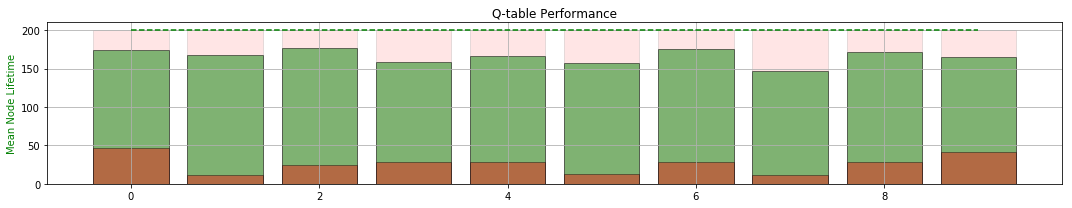

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 113.293	LOSS : 164.143	LOSS : 120.730	LOSS : 120.543	LOSS : 126.983	LOSS : 138.625	LOSS : 130.465	LOSS : 120.720	LOSS : 129.842	LOSS : 107.883	LOSS : 127.896	LOSS : 95.992	LOSS : 119.447	LOSS : 115.055	LOSS : 115.637	LOSS : 123.389	LOSS : 112.354	LOSS : 111.828	LOSS : 107.714	LOSS : 106.055	
Validating... MEAN TIME:  123.015
LOSS : 102.705	LOSS : 102.163	LOSS : 106.824	LOSS : 97.241	LOSS : 108.461	LOSS : 72.466	LOSS : 101.877	LOSS : 103.137	LOSS : 107.073	LOSS : 91.275	LOSS : 89.217	LOSS : 79.152	LOSS : 83.051	LOSS : 98.243	LOSS : 110.455	LOSS : 88.000	LOSS : 98.838	LOSS : 89.804	LOSS : 92.328	LOSS : 78.122	
Validating... MEAN TIME:  101.545
LOSS : 107.803	LOSS : 95.937	LOSS : 84.094	LOSS : 96.675	LOSS : 68.634	LOSS : 85.973	LOSS : 89.571	LOSS : 96.200	LOSS : 85.098	LOSS : 83.274	LOSS : 101.685	LOSS : 85.004	LOSS : 89.135	LOSS : 86.201	LOSS : 122.749	LOSS : 109.578	LOSS : 89.192	LOSS : 67.628	LOSS

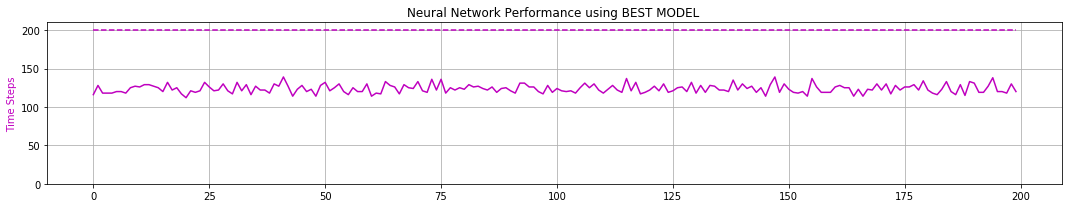

peak memory: 1508.19 MiB, increment: 1017.14 MiB
0 -max- [ 2.383  2.167  0.209  2.357]
0 -min- [-2.399 -2.808 -0.209 -2.258]

1 -max- [ 0.192  1.406  0.207  2.297]
1 -min- [-2.400 -2.982 -0.209 -1.982]

2 -max- [ 0.592  1.760  0.209  2.386]
2 -min- [-2.398 -2.815 -0.209 -2.064]

3 -max- [ 0.476  1.599  0.209  2.247]
3 -min- [-2.400 -2.987 -0.209 -2.249]

4 -max- [ 0.751  1.684  0.208  2.515]
4 -min- [-2.398 -2.796 -0.209 -2.060]

5 -max- [ 0.253  1.582  0.207  2.386]
5 -min- [-2.400 -2.926 -0.209 -2.028]

6 -max- [ 1.391  2.028  0.209  2.562]
6 -min- [-2.400 -2.793 -0.209 -2.133]

7 -max- [ 0.209  1.401  0.206  2.258]
7 -min- [-2.398 -2.959 -0.209 -2.198]

8 -max- [ 0.644  1.871  0.206  2.368]
8 -min- [-2.399 -2.956 -0.209 -2.028]

9 -max- [ 0.626  1.765  0.207  2.342]
9 -min- [-2.398 -2.809 -0.209 -2.169]

Quantization TIME:  0.01 minutes


ITERATION # 12
TOTAL EXPERIENCE GENERATED:   110866
SMALLEST TIMESTEP: 68
LARGEST  TIMESTEP: 128
TOTAL SERIAL TIMESTEPS:   1337077
TOTAL PARALLEL 

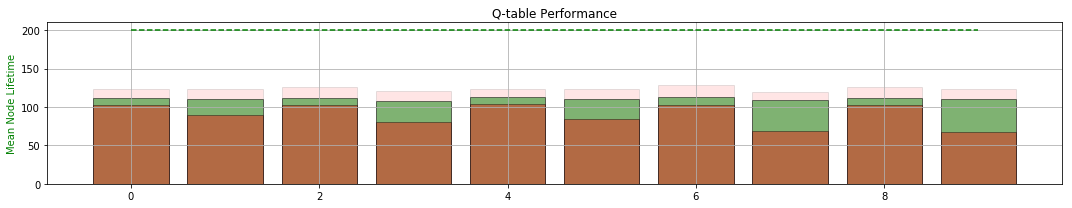

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 125.951	LOSS : 139.397	LOSS : 123.516	LOSS : 136.361	LOSS : 136.933	LOSS : 133.362	LOSS : 149.475	LOSS : 168.818	LOSS : 137.733	LOSS : 170.486	LOSS : 167.005	LOSS : 138.867	LOSS : 123.415	LOSS : 147.925	LOSS : 132.980	LOSS : 137.770	LOSS : 119.206	LOSS : 140.147	LOSS : 137.828	LOSS : 147.056	
Validating... MEAN TIME:  199.72
LOSS : 150.356	LOSS : 158.045	LOSS : 134.739	LOSS : 124.901	LOSS : 135.266	LOSS : 146.499	LOSS : 171.291	LOSS : 125.857	LOSS : 139.713	LOSS : 153.064	LOSS : 156.377	LOSS : 133.272	LOSS : 143.666	LOSS : 129.968	LOSS : 125.994	LOSS : 128.776	LOSS : 138.661	LOSS : 127.880	LOSS : 156.162	LOSS : 145.415	
Validating... MEAN TIME:  136.085
LOSS : 164.596	LOSS : 127.918	LOSS : 120.156	LOSS : 133.798	LOSS : 138.880	LOSS : 103.978	LOSS : 123.491	LOSS : 111.354	LOSS : 126.387	LOSS : 116.800	LOSS : 131.023	LOSS : 118.251	LOSS : 136.387	LOSS : 119.027	LOSS : 112.889	LOSS : 118.564	LOSS : 1

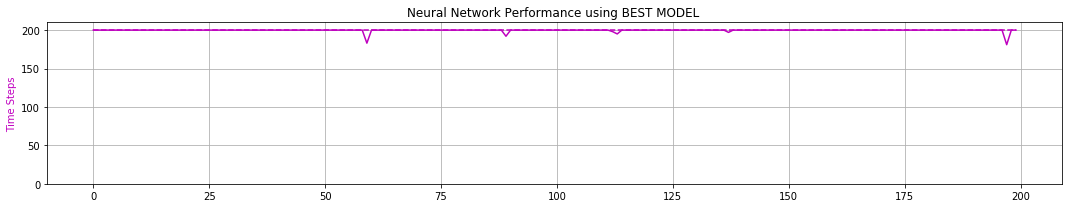

peak memory: 1472.01 MiB, increment: 1035.73 MiB
0 -max- [ 0.130  0.967  0.050  0.659]
0 -min- [-2.400 -3.320 -0.204 -1.343]

1 -max- [ 0.139  0.821  0.046  0.578]
1 -min- [-2.399 -3.265 -0.209 -1.175]

2 -max- [ 0.141  0.828  0.050  0.850]
2 -min- [-2.400 -3.445 -0.205 -1.166]

3 -max- [ 0.140  1.005  0.047  0.687]
3 -min- [-2.399 -3.149 -0.209 -1.500]

4 -max- [ 0.136  0.958  0.051  0.690]
4 -min- [-2.400 -3.280 -0.204 -1.349]

5 -max- [ 0.143  0.813  0.047  0.644]
5 -min- [-2.400 -3.268 -0.209 -1.172]

6 -max- [ 0.154  0.987  0.051  0.665]
6 -min- [-2.399 -3.270 -0.205 -1.358]

7 -max- [ 0.141  0.991  0.050  0.517]
7 -min- [-2.400 -3.152 -0.209 -1.368]

8 -max- [ 0.144  1.002  0.051  0.667]
8 -min- [-2.398 -3.266 -0.204 -1.357]

9 -max- [ 0.161  1.008  0.050  0.708]
9 -min- [-2.399 -3.155 -0.209 -1.392]

Quantization TIME:  0.02 minutes


ITERATION # 13
TOTAL EXPERIENCE GENERATED:   198921
SMALLEST TIMESTEP: 170
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   1535998
TOTAL PARALLEL

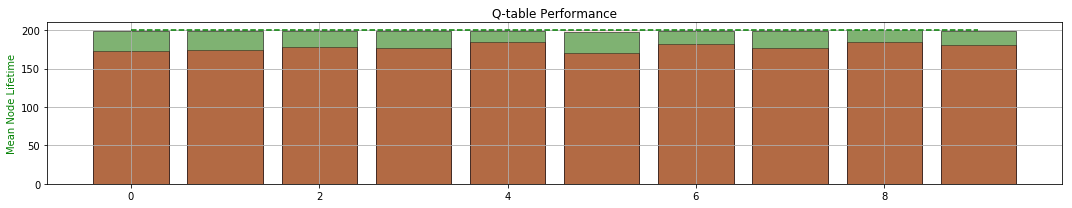

In [20]:
while iteration < MAX_NO_OF_ITERATIONS:

    print("\n")
    print("ITERATION #", iteration)
    tic = datetime.now()
    
    # MAP GYM ENVIRONMENT TO EACH PROCESS IN THE POOL
    ##################################################################
    q_table_list = [node_q_table]* NO_OF_NODES
    iter_list = [iteration] * NO_OF_NODES
    arg_list = [arg for arg in zip(range(NO_OF_NODES), node_boundaries, iter_list, q_table_list)]
    result   = pool.starmap(mp_node_run, arg_list)
    ##################################################################
    
    # GATHER RESULTS
    ##################################################################
    node_boundaries = np.array([item[2] for item in result])
    node_time_rec   = np.array([item[1] for item in result])
    node_exp        = np.array([item[0] for item in result])
    
    all_exp         = np.array([item for each_node_exp in node_exp 
                                    for episode_exp in each_node_exp 
                                    for item in episode_exp]).reshape(-1,N_STATES*2+2)
    total_parallel_timesteps += node_time_rec.max()
    total_serial_timesteps   += node_time_rec.sum()
    EXP_GEN = node_time_rec.sum().astype(int)
    
    print("TOTAL EXPERIENCE GENERATED:   {:d}".format(EXP_GEN.astype(int)))

    print("SMALLEST TIMESTEP: {:d}".format(node_time_rec.min().astype(int)))
    print("LARGEST  TIMESTEP: {:d}".format(node_time_rec.max().astype(int)))

    print("TOTAL SERIAL TIMESTEPS:   {:d}".format(total_serial_timesteps.astype(int)))
    print("TOTAL PARALLEL TIMESTEPS: {:d}".format(total_parallel_timesteps.astype(int)))
    ##################################################################

    # PLOT EXPERIENCES
    ##################################################################
    node_avg_time = node_time_rec.mean(axis=1)
    node_std_time = node_time_rec.std(axis=1)
    node_max_time = node_time_rec.max(axis=1)
    node_min_time = node_time_rec.min(axis=1)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    ax2.set_title("Q-table Performance")
    ax2.bar(range(NO_OF_NODES) , node_max_time, alpha = 0.1, color = 'r', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_avg_time, alpha = 0.5, color = 'g', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_min_time, alpha = 0.4, color = 'r', edgecolor = 'black', capsize=7 )

    ax2.plot(np.ones_like(node_avg_time)*200, 'g--')
    ax2.set_ylabel('Mean Node Lifetime',color = 'g')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    ##################################################################
    
    if node_avg_time[node_avg_time >= 195].shape[0] > NO_OF_NODES/2:
        final_result = "SUCCESS"
        break

    # SEGREGATE AND STORE EXPERIENCES
    ##################################################################
    dqn.memory = np.insert(dqn.memory,0,all_exp,0)
    dqn.memory = dqn.memory[:MIN_MEMORY_CAP,:]
    dqn.memory_counter += all_exp.shape[0]
#     good_mem = all_exp[all_exp[:,N_STATES+1] == 1]    
#     bad_mem  = all_exp[all_exp[:,N_STATES+1] < 1]


#     dqn.good_memory = np.insert(dqn.good_memory, 0, good_mem , 0)
#     dqn.good_memory_counter += good_mem.shape[0]

#     dqn.bad_memory  = np.insert(dqn.bad_memory, 0, bad_mem , 0)
#     dqn.bad_memory_counter += bad_mem.shape[0]

#     dqn.good_memory = dqn.good_memory[:MIN_MEMORY_CAP,:]
#     dqn.bad_memory = dqn.bad_memory[:MIN_MEMORY_CAP,:]

    NN_ITERATIONS = MAX_NN_ITERATIONS
    print("MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.memory_counter))

#     print("GOOD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.good_memory_counter))
#     print("BAD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.bad_memory_counter))
    ##################################################################

    # LEARN
    ##################################################################
    print("Training Neural Network for", NN_ITERATIONS, "iterations", "@ LR = ", NN_LR)
    tic=datetime.now()
    nn_level_up_metric = 0
    for nn_iter in range(NN_ITERATIONS):
        dqn.learn()
        #validate by running for TIMESTEP_LIMIT iterations
        if(nn_iter%int(NN_ITERATIONS/5) == int(NN_ITERATIONS/5)-1):
            print("\nValidating... ",end="")
            time_rec = []
            for i_episode in range(TIMESTEP_LIMIT):
                time_step = 0
                s = v_env.reset()

                while True:
                    time_step += 1 
                    a = dqn.choose_greedy_action(s)
                    s_, r, done, info = v_env.step(a)

                    if done:
                        break
                    s = s_
                time_rec = np.append(time_rec, time_step)
            mean_time = time_rec.mean()
            print("MEAN TIME: ", mean_time)
            if mean_time >= nn_level_up_metric:
                nn_level_up_metric = mean_time
                nn_level_up_metric = clamp(0, nn_level_up_metric, 195)
                torch.save(dqn.eval_net.state_dict(), MODEL_FILENAME)

    print("TRAINING TIME:{}".format(datetime.now()-tic))
    ##################################################################

    # CHECK PERFORMANCE OF THE BEST MODEL
    ##################################################################
    best_dqn = D3QN()
    best_dqn.eval_net.load_state_dict(torch.load(MODEL_FILENAME))
    best_dqn.eval_net.eval()

    time_rec = []
    for i_episode in range(TIMESTEP_LIMIT):
        time_step = 0
        s = env.reset()

        while True:
    #         env.render()
            time_step += 1 
            a = best_dqn.choose_greedy_action(s)
            s_, r, done, info = env.step(a)
            if done:
                break
            s = s_
        time_rec = np.append(time_rec, time_step)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    data = time_rec
    ax2.plot(data, color = 'm')
    ax2.plot(np.ones_like(data)*200, 'm--')
    ax2.set_title('Neural Network Performance using BEST MODEL ')
    ax2.set_ylabel('Time Steps',color = 'm')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    
    
        
    ##################################################################
    
    # CREATE ONE LARGE Q-TABLES FROM WHICH THE NODES STRIP
    ##################################################################
        
#     node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
#                                         [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
#                                         [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN * NO_OF_NODES  ])
    
    start = timeit.default_timer()
    # GET Q-VALUES 
    %memit node_q_table = best_dqn.get_greedy_action(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN).astype(np.intp)

    # SAVE QFILE
#     np.save(node_QFILE, node_q_table)
    stop = timeit.default_timer()

#     ##################################################################
    
#     # CREATE INDIVIDUALIZED Q-TABLES FOR THE NODES
#     ##################################################################
    
    for node_id in range(NO_OF_NODES):
# #         # SET STATE VALUE BORDERS AS REQUESTED BY THE NODE
# #         ###############################################
#         [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
#          C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]  = node_boundaries[node_id]
# #         ###############################################
        print(node_id,'-max-',node_boundaries[node_id][:N_STATES])
        print(node_id,'-min-',node_boundaries[node_id][N_STATES:])
        print("")
        
# #         node_boundaries[node_id] = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_MAX,
# #                                     C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_MIN]
# #         # CREATE STATE COMBINATIONS
# #         ###############################################

#     node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
#                                         [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
#                                         [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN   ])
#         ###############################################
#     start = timeit.default_timer()
#     # GET Q-VALUES 
#     %memit node_q_table = best_dqn.get_qvals(node_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN , -1).astype(np.float16)

#     # SAVE QFILE
#     np.save(node_QFILE, node_q_table)
#         #############################################################################################################################################
#     stop = timeit.default_timer()
    print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    iteration += 1
pool.close()
pool.join()

In [21]:
print("Total Parallel Timesteps : ", total_parallel_timesteps)
print("Total Serial Timesteps   : ", total_serial_timesteps)
print("Speed-up                 :  {:6.2f}".format(total_serial_timesteps/total_parallel_timesteps))

Total Parallel Timesteps :  2292.0
Total Serial Timesteps   :  1535998.0
Speed-up                 :  670.16


In [22]:
pool.close()
pool.join()
if iteration == MAX_NO_OF_ITERATIONS:
    final_result = "FAILURE"

In [23]:
print("{:6d} {} {:3d} {:3d} {:7d} {:10d} {:10.2f}".format(seed, final_result, int(node_min_time.min()), int(iteration), int(total_parallel_timesteps), int(total_serial_timesteps), total_serial_timesteps/total_parallel_timesteps))

   862 SUCCESS 170  13    2292    1535998     670.16
